# Crypto Forecasting Kaggle Project – Feature Selection
# DRW Crypto Prediction – Feature Selection (Part 1/2)

Goal: Identify the 15 most predictive features from 785 raw inputs using three complementary methods:
- SHAP values (LightGBM)
- Mutual Information
- Permutation Importance

In [12]:
#Imports
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
import shap
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance


# Splitting the dataset, test and train

In [13]:
train = pd.read_parquet('train.parquet')
test = pd.read_parquet('test.parquet')
train = pd.read_parquet('train.parquet')
feature_cols = [col for col in train.columns if col.startswith('X') or col in [
    'bid_qty', 'ask_qty', 'buy_qty', 'sell_qty', 'volume']] 

X = train[feature_cols]
y = train['label']


# Training a simple model

In [14]:
# Split dataset into training and validation sets (80/20) for model evaluation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a simple LightGBM regressor on the training data
model = LGBMRegressor(n_estimators=100, learning_rate=0.05, random_state=42)
model.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.080154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 200155
[LightGBM] [Info] Number of data points in the train set: 420708, number of used features: 785
[LightGBM] [Info] Start training from score 0.037921


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


# SHAP (Numbers and Graph)

Top SHAP features:
 X752    0.034533
X759    0.029363
X444    0.029000
X758    0.028037
X445    0.025683
X344    0.023521
X757    0.022406
X613    0.019586
X751    0.012202
X570    0.011024
dtype: float64


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


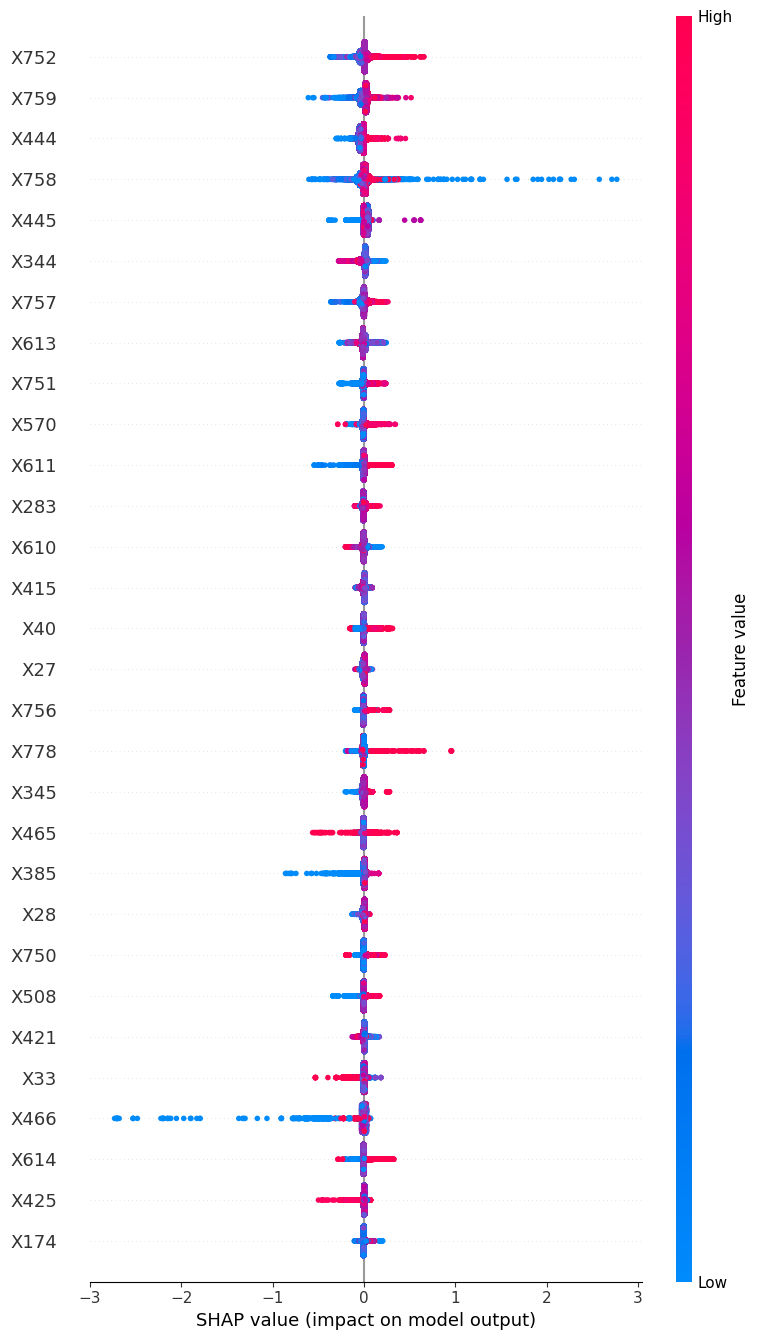

In [15]:
# SHAP feature importance
explainer = shap.Explainer(model)
shap_values = explainer(X_val)
shap_scores = np.abs(shap_values.values).mean(axis=0)
shap_importance = pd.Series(shap_scores, index=X_val.columns).sort_values(ascending=False)

# Top features
top_n = 30
top_shap_features = shap_importance.head(top_n).index.tolist()
print("Top SHAP features:\n", shap_importance.head(10))

# Plot summary
shap.summary_plot(shap_values, X_val, max_display=top_n)


# Comparing Mutual Information and Permutation Importance 


Top MI features among SHAP shortlist:
 X778    0.076911
X758    0.067362
X611    0.064773
X345    0.062889
X466    0.057032
X614    0.054127
X613    0.052162
X344    0.051619
X465    0.050942
X385    0.049181
dtype: float64
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 420708, number of used features: 20
[LightGBM] [Info] Start training from score 0.025639

Top Permutation Importances:
 X614    0.082227
X758    0.078096
X750    0.040950
X778    0.016517
X610    0.012641
X421    0.009985
X385    0.007147
X611    0.006890
X445    0.004853
X344    0.004471
dtype: float64


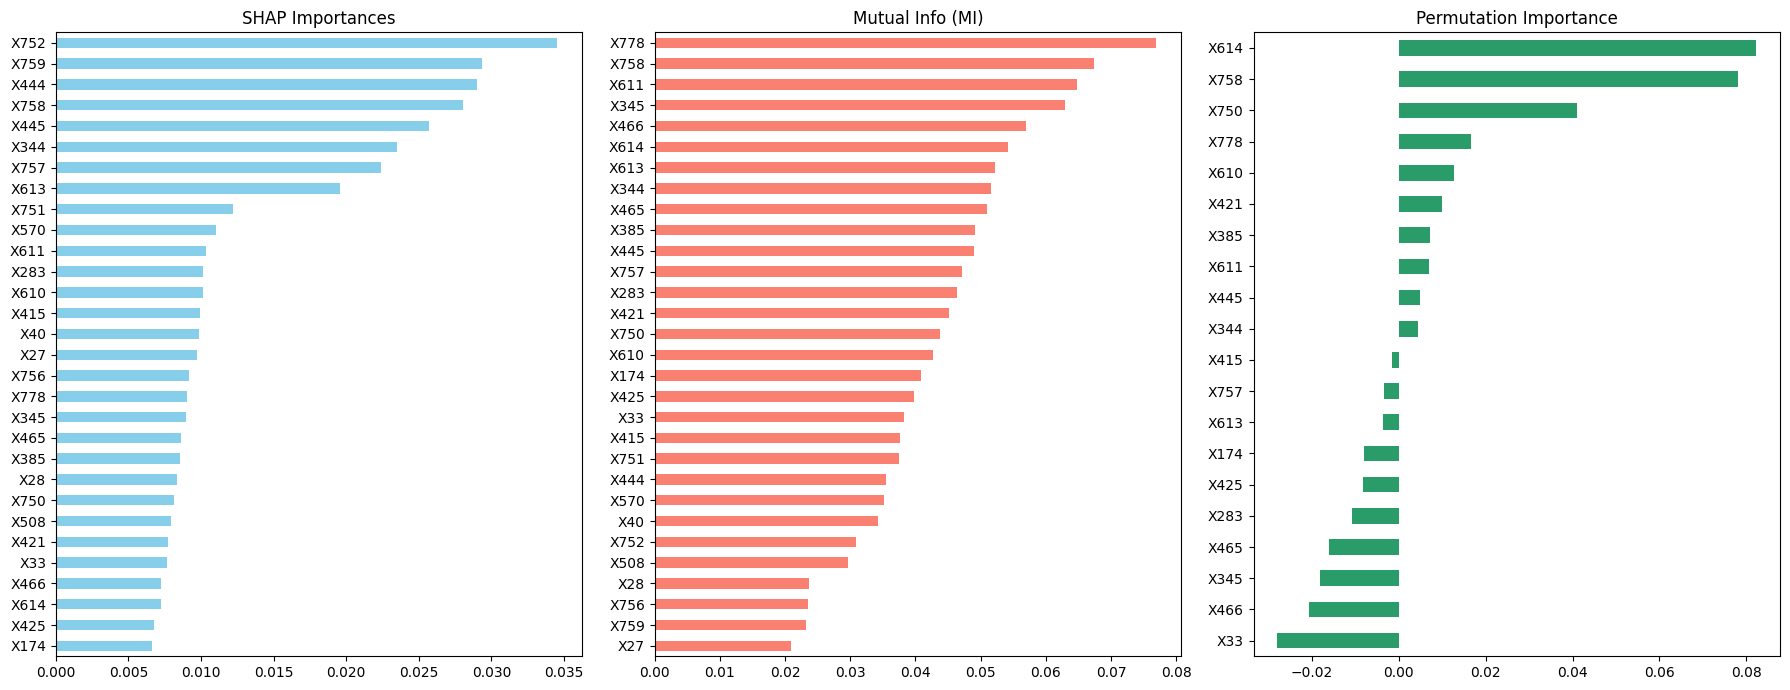

In [16]:
# Mutual Information on top SHAP features
mi = mutual_info_regression(X_val[top_shap_features].fillna(0), y_val, n_jobs=-1)
mi_series = pd.Series(mi, index=top_shap_features).sort_values(ascending=False)
print("\nTop MI features among SHAP shortlist:\n", mi_series.head(10))

# Select top features for training/validation split
top_feats = mi_series.head(20).index.tolist()
split_idx = int(0.8 * len(train))
X_train = train[top_feats].iloc[:split_idx]
y_train = train['label'].iloc[:split_idx]
X_val = train[top_feats].iloc[split_idx:]
y_val = train['label'].iloc[split_idx:]

# Train model
model = LGBMRegressor(n_estimators=500, learning_rate=0.05, random_state=42)
model.fit(X_train, y_train)

# Permutation Importance on validation set
perm = permutation_importance(
    model, X_val, y_val,
    scoring='neg_root_mean_squared_error',
    n_repeats=5, random_state=42, n_jobs=-1
)
perm_series = pd.Series(perm.importances_mean, index=top_feats).sort_values(ascending=False)
print("\nTop Permutation Importances:\n", perm_series.head(10))

# Compare SHAP, MI, and Permutation importances
fig, axes = plt.subplots(1, 3, figsize=(18, 7))
shap_importance[top_shap_features].iloc[::-1].plot.barh(ax=axes[0], color='skyblue')
axes[0].set_title('SHAP Importances')
mi_series.iloc[::-1].plot.barh(ax=axes[1], color='salmon')
axes[1].set_title('Mutual Info (MI)')
perm_series.iloc[::-1].plot.barh(ax=axes[2], color='#2a9c6a')
axes[2].set_title('Permutation Importance')
plt.tight_layout()
plt.show()


Based on the combination of SHAP values, Mutual Information, and Permutation Importance, we selected a set of robust features for model training. Features that appeared consistently across multiple methods and had high importance scores were prioritized. The final set of selected features includes: X344, X345, X758, X466, X385, X611, X778, X613, X614, X750, X283, X33, X174, X421, X610. These features will be used as input for the subsequent neural network and regression modeling to forecast cryptocurrency price movements.

In [17]:
["X344", "X345", "X758", "X466", "X385", "X611", "X778", "X613", "X614", "X750", "X283", "X33", "X174", "X421", "X610"]


['X344',
 'X345',
 'X758',
 'X466',
 'X385',
 'X611',
 'X778',
 'X613',
 'X614',
 'X750',
 'X283',
 'X33',
 'X174',
 'X421',
 'X610']